In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.metrics import Precision, Recall, F1Score
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import LSTM, Dense, Embedding, BatchNormalization, Dropout
import seaborn as sns

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [ ]:
# Đây là mô hình được thực hiện train trên Kaggle
# https://www.kaggle.com/code/vtrhieu/vietnamese-sentiment-analysis

# **Get data**

In [2]:
path = '/kaggle/input/vietnamese-sentiment-analyst/data.csv'
df = pd.read_csv(path)

In [3]:
df.head()

,content,label,start
0,Áo bao đẹp ạ!,POS,5
1,Tuyệt vời,POS,5
2,2day ao khong giong trong,NEG,1
3,"Mùi thơm,bôi lên da mềm da",POS,5
4,"Vải đẹp, dày dặn",POS,5


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31460 entries, 0 to 31459
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   content  31436 non-null  object
 1   label    31460 non-null  object
 2   start    31460 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 737.5+ KB


# **Preprocessing**

In [5]:
print(df.isna().sum())

content    24
label       0
start       0
dtype: int64


In [6]:
print(df.duplicated().sum())

4259


In [7]:
df.dropna(inplace=True)

df.drop_duplicates(inplace=True)

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


Text(0.5, 1.0, 'Number of labels')

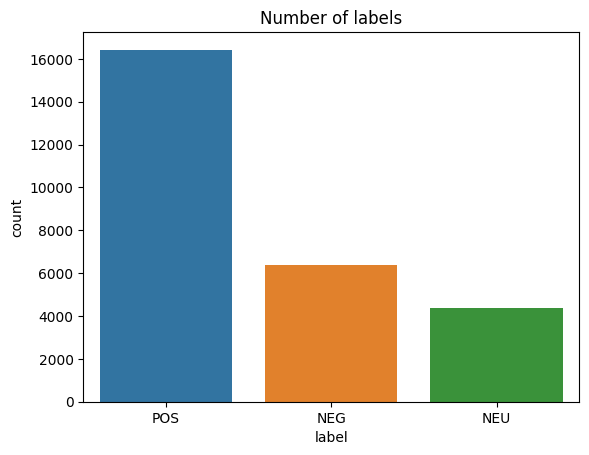

In [8]:
sns.countplot(data=df, x='label')
plt.xlabel('label')
plt.title('Number of labels')

# **Train, val, test set**

In [9]:
x = df['content']
y = df['label']

In [10]:
y.head()

0    POS
1    POS
2    NEG
3    POS
4    POS
Name: label, dtype: object

In [11]:
def sentiment_to_one_hot(sentiment_state):
    if sentiment_state == 'POS':
        return [0, 0, 1]
    elif sentiment_state == 'NEU':
        return [0, 1, 0]
    elif sentiment_state == 'NEG':
        return [1, 0, 0]
    else:
        return [0, 0, 0]

In [12]:
y

0        POS
1        POS
2        NEG
3        POS
4        POS
        ... 
31452    POS
31454    NEU
31457    POS
31458    POS
31459    POS
Name: label, Length: 27196, dtype: object

In [13]:
y_label = np.array(list(map(sentiment_to_one_hot, y)))

In [14]:
y_label

array([[0, 0, 1],
       [0, 0, 1],
       [1, 0, 0],
       ...,
       [0, 0, 1],
       [0, 0, 1],
       [0, 0, 1]])

In [15]:
y = y_label

In [16]:
# chia dataset thành train/val/test set với tỉ lệ 0.6/0.2/0.2
x_train, x_untrained, y_train, y_untrained = train_test_split(x, y, test_size = 0.4, random_state = 10)
x_val, x_test, y_val, y_test = train_test_split(x_untrained, y_untrained, test_size = 0.5, random_state = 10)

In [17]:
sample = x_train[0: 10]
sample.values

array(['Chất lượng sản phẩm tuyệt vời, đóng gói sản phẩm rất đẹp và chắc chắn, shop phục vụ rất tốt, rất đáng tiền, thời gian giao hàng rất nhanh, chủ shop tư vấn nhiệt tình và thân thiện, áo chuẩn như hình và vãi áo rất mịn đẹp mặc rất thoải mái, giá cả lại hợp với túi tiền',
       'Shop phục vụ rất tốt Shop phục vụ rất tốt Shop phục vụ rất tốt',
       'Hàng rất đẹp rất ưng ý,giao hàng nhanh đóng gói cẩn thận',
       'Sẽ theo shop dài dài', 'Rất ưng ý với sp',
       'Chất dày dặn mặc rất thoải mái Thời gian giao hàng rất nhanh',
       'Đẹp..chất', 'Chưa ăn nhưng nhìn thôi đã thấy ngon rồi', 'Đẹp :)',
       'Hơi xấu so với 2 màu kia :v'], dtype=object)

In [18]:
x_train.shape

(16317,)

In [19]:
max_words = 10000
max_len = 150
tok = Tokenizer(num_words = max_words)

# fit_on_texts: tạo ra 1 từ vựng từ training_set với kích thước max_words
# texts_to_sequences: chuyển đổi mỗi từ trong câu thành 1 số nguyên dựa trên từ vựng
# pad_sequences: cắt bớt hoặc chèn thêm 0 vào mỗi vector từ để được kích thước max_len
tok.fit_on_texts(x_train)
sequences = tok.texts_to_sequences(x_train)
sequences_matrix = pad_sequences(sequences, maxlen = max_len)

val_sequences = tok.texts_to_sequences(x_val)
val_sequences_matrix = pad_sequences(val_sequences, maxlen = max_len)

test_sequences = tok.texts_to_sequences(x_test)
test_sequences_matrix = pad_sequences(test_sequences, maxlen = max_len)

In [20]:
y_test.shape

(5440, 3)

In [21]:
print(sequences[0])

[5, 8, 3, 4, 12, 15, 16, 14, 3, 4, 1, 2, 11, 20, 22, 6, 25, 27, 1, 13, 1, 24, 18, 28, 26, 9, 7, 1, 17, 96, 6, 121, 117, 68, 63, 11, 329, 363, 10, 162, 39, 29, 11, 358, 10, 1, 149, 2, 33, 1, 213, 215, 36, 113, 51, 99, 46, 123, 18]


In [22]:
sequences_matrix

array([[   0,    0,    0, ...,   46,  123,   18],
       [   0,    0,    0, ...,   27,    1,   13],
       [   0,    0,    0, ...,   14,  190,  186],
       ...,
       [   0,    0,    0, ...,    7,  148,   17],
       [   0,    0,    0, ...,   40,   49, 1560],
       [   0,    0,    0, ...,  104,   87,  483]], dtype=int32)

In [23]:
sequences_matrix.shape, val_sequences_matrix.shape, test_sequences_matrix.shape

((16317, 150), (5439, 150), (5440, 150))

# **Model**

In [24]:
model = Sequential([
    Embedding(10000, 32),
#     BatchNormalization(),
#     Dropout(rate = 0.2),
    
    LSTM(32, activation= 'sigmoid',),
    Dense(3, activation='softmax')
])


In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 32)          320000    
                                                                 
 lstm (LSTM)                 (None, 32)                8320      
                                                                 
 dense (Dense)               (None, 3)                 99        
                                                                 
Total params: 328419 (1.25 MB)
Trainable params: 328419 (1.25 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [26]:
# model.load_weights('/kaggle/working/weight2.h5')

In [27]:
optimizer = Adam(learning_rate = 1e-3)

In [28]:
# sử dụng binary_cross_entropy_loss
# hàm tối ưu Adam
model.compile(optimizer = optimizer, loss = 'categorical_crossentropy', metrics = ['accuracy', Precision(), Recall()])

# **Train**

In [29]:
history = model.fit(sequences_matrix, y_train, epochs=20, batch_size=128, validation_data = (val_sequences_matrix, y_val))

Epoch 1/20
128/128 [==============================] - 56s 371ms/step - loss: 0.8940 - accuracy: 0.6063 - precision: 0.6232 - recall: 0.5931 - val_loss: 0.7824 - val_accuracy: 0.6395 - val_precision: 0.7617 - val_recall: 0.5336
Epoch 2/20
128/128 [==============================] - 37s 287ms/step - loss: 0.6824 - accuracy: 0.7162 - precision: 0.8088 - recall: 0.5996 - val_loss: 0.6608 - val_accuracy: 0.7209 - val_precision: 0.7739 - val_recall: 0.6589
Epoch 3/20
128/128 [==============================] - 33s 257ms/step - loss: 0.5867 - accuracy: 0.7609 - precision: 0.8238 - recall: 0.6915 - val_loss: 0.6036 - val_accuracy: 0.7500 - val_precision: 0.8094 - val_recall: 0.6904
Epoch 4/20
128/128 [==============================] - 33s 256ms/step - loss: 0.5522 - accuracy: 0.7756 - precision: 0.8341 - recall: 0.7132 - val_loss: 0.6003 - val_accuracy: 0.7562 - val_precision: 0.8174 - val_recall: 0.6896
Epoch 5/20
128/128 [==============================] - 32s 250ms/step - loss: 0.5236 - accura

In [30]:
results = model.evaluate(test_sequences_matrix, y_test)
loss = results[0]
accuracy = results[1]

print(f"Model Loss: {loss}")
print(f"Model Accuracy: {accuracy*100}")

170/170 [==============================] - 3s 20ms/step - loss: 0.7661 - accuracy: 0.7316 - precision: 0.7513 - recall: 0.7013
Model Loss: 0.766052782535553
Model Accuracy: 73.16176295280457


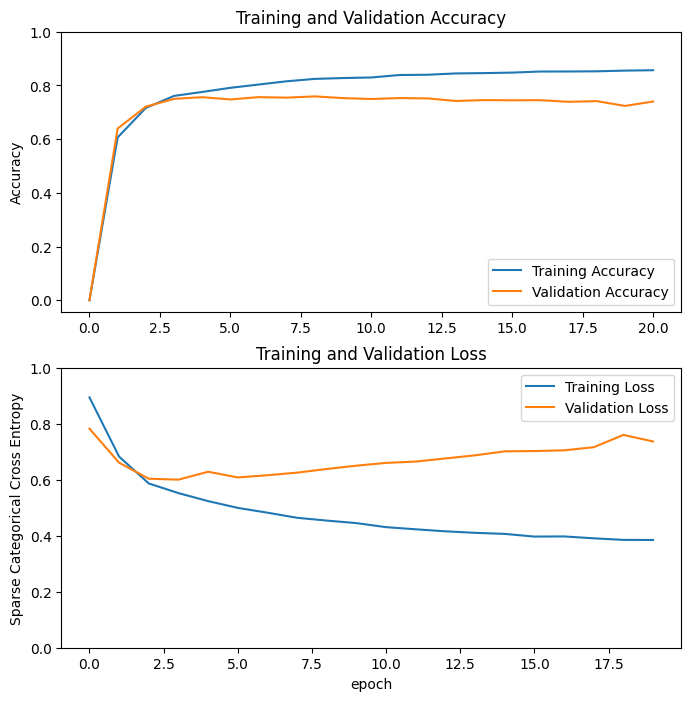

In [42]:
acc = [0.] + history.history['accuracy']
val_acc = [0.] + history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Sparse Categorical Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# **Predict**

In [32]:
predict_sequences = tok.texts_to_sequences(sample)
predict_sequences_matrix = pad_sequences(predict_sequences, maxlen = max_len)

In [33]:
predict_sequences_matrix.shape

(10, 150)

In [34]:
y_pred_prob = model.predict(predict_sequences_matrix)

1/1 [==============================] - 0s 212ms/step


In [38]:
y_pred = np.array(list(map(np.argmax, y_pred_prob)))

In [43]:
y_pred

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 0])

In [54]:
id_to_category = {0: 'NEG', 1: 'NEU', 2: 'POS'}
output_label = [id_to_category[y_pred[idx]] for idx in range(len(y_pred))]
output_label

['POS', 'POS', 'POS', 'POS', 'POS', 'POS', 'POS', 'POS', 'POS', 'NEG']

In [ ]:
model.save_weights('/kaggle/working/weight2.h5')

In [ ]:
# Save the tokenizer
tok_json = tok.to_json()
with open('tokenizer.json', 'w', encoding='utf-8') as json_file:
    json_file.write(tok_json)